In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from tqdm import tqdm

from spatgame import evolve, evolve_old
from meangame import MeanGamePy as MeanGame
from game import GameField as SelfGame

In [2]:
plt.style.use("seaborn-whitegrid")

In this game $L^2$ individual "*players*" placed in a two-dimensional spatial array.

Every individual can play one of two tactics: cooperate($\mathcal{C}$) or defect($\mathcal{D}$). At the beginning of the "game", each player has the probability of being assigned $\mathcal{C}$ with probability $p_c$ and tactics $\mathcal{D}$ otherwise.

In each round individuals "*play the game*" with 8 its neighbors and the *average cooperator*. Tables of payoffs shown below

Table: Payoffs for games with neighbors.

| payoffs | $\mathcal{D}$ | $\mathcal{C}$ |
| --------- |:-------------:|----:|
| $\mathcal{D}$ | 0 | 0 |
| $\mathcal{C}$ | $b$ | 1 |

Table: Payoffs for games with *average cooperator*

| payoffs | $\mathcal{D}$ | $\mathcal{C}$ |
| --------- |:-------------:|----:|
| $\mathcal{D}$ | 0 | 0 |
| $\mathcal{C}$ | $b f_c$ | $f_c$ |

After playing all games the site occupied either by its original owner or by one of the neighbors who scores the highest total payoff in that round.

In [3]:
Ls = [20, 50, 100, 200]
bs = np.linspace(.9, 2, 60)

seeds = [5,58,4785,45895,1256,65478,854,126,42,1458,458,96324,985423,85456, 4585, 8956, 8596589,89589,74,658,84,845,9,55,489, 32,456,345,876,6, 457, 34,67,444,666, 5678, 98, 65, 389, 8765]
p_c = .9 # probability of being assigned strategy C

In [20]:
for L in Ls:
    for idx, seed in enumerate(seeds):
        np.random.seed(seed)
        np.save("fields/field_{}_{}.npy".format(L, idx), np.random.choice((0, 1), (L, L), p=(1-p_c, p_c)))

<IPython.core.display.Javascript object>


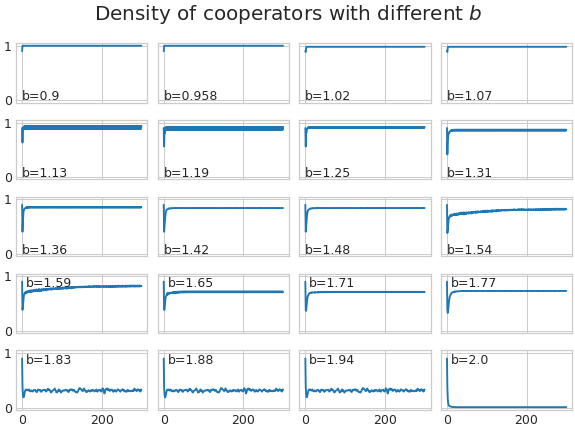

100%|██████████| 20/20 [00:14<00:00,  1.31it/s]


In [7]:
fig, axs = plt.subplots(5, 4, constrained_layout=True, sharex=True, sharey=True)
fig.suptitle('Density of cooperators with different $b$', fontsize=16)
for i, b in tqdm(enumerate(np.linspace(.9, 2, 20)), total=20):
    for n in [29]:
        field = np.load("fields/field_100_{}.npy".format(n))
        d = [field.sum()/(1.*field.shape[0]**2)]
        for _ in range(int(300)):
            field = evolve_old(field, b, 1)
            d.append(field.sum()/(1.*field.shape[0]**2))
        axs[i//4, i % 4].plot(d)
        if i > 11:
            axs[i//4, i % 4].text(10, 0.8, "b={:.3}".format(b, fontsize=11))
        else:
            axs[i//4, i % 4].text(0, 0, "b={:.3}".format(b, fontsize=11))

plt.show()

In [7]:
fig.savefig("figures/f_c_for_different_b.jpg", dpi=300, quality=95)

<IPython.core.display.Javascript object>


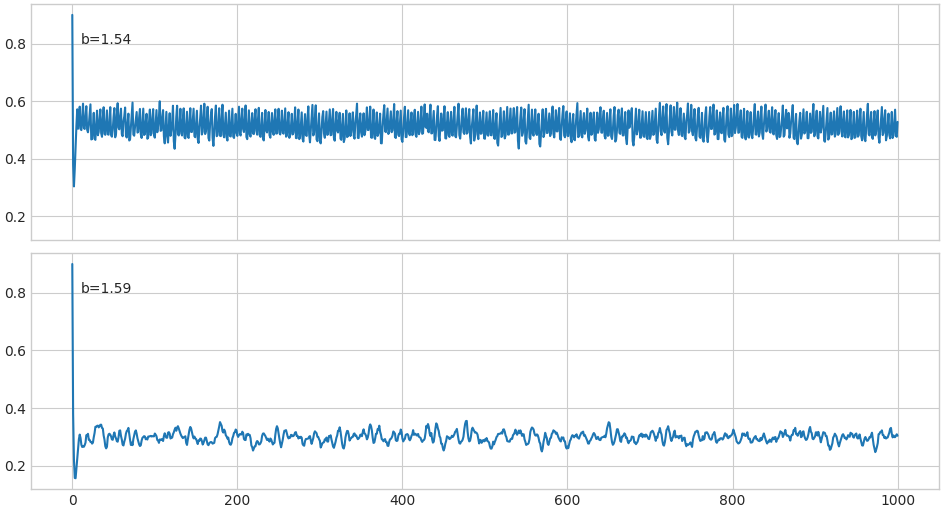

In [13]:
fig, axs = plt.subplots(2, 1, constrained_layout=True, sharex=True, sharey=True)
for i, b in enumerate([1.54, 1.59]):
    for n in [29]:
        field = np.load("fields/field_100_{}.npy".format(n))
        d = [field.sum()/(1.*field.shape[0]**2)]
        for _ in range(int(1000)):
            field = evolve(field, b, 1)
            d.append(field.sum()/(1.*field.shape[0]**2))
        axs[i].plot(d)
        axs[i].text(10, 0.8, "b={:.3}".format(b, fontsize=11))

As shown in figure above density of the cooperators become stable after 100 steps for all $b$ and oscilates with different frequency and amplitude around mean values.

In [4]:
DROP = 10000
CALC = 18*10**3
EVERY = 1
L = 100

## Transition values(local)

The game is defined by the payoff $b$ and different behaviour is expected at different $b$

To find the values of $b$ at which transition occurs we have to understand at which values the total outcome of agent may change.


<img src="./neighbourhoods.png" alt="drawing" width="300"/>

By looking at picture above we can come up with this formuls for $b$
$$b=\frac{n_{c\;shared}+n_c+f_c}{n_{c\;shared}+n_d+f_c+1}$$
for left hand side configurations

$$b=\frac{n_{c\;shared}+n_c+f_c}{n_{c\;shared}+n_d+f_c}$$
for right hand side configurations

Where

$n_{c\;shared}$ - number of cooperators($\mathcal{C}$) from red region

$n_c$ - number of cooperators near cooperator(purple region)

$n_d$ - number of cooperators near defector(yellow region)

$f_c$ - density of cooperators

In [20]:
def with_agents(f_c, n_share, n_c, n_d):
    return (n_share+n_c+f_c)/(n_share+n_d+f_c+1)

def without_agents(f_c, n_share, n_c, n_d):
    return (n_share+n_c+f_c)/(n_share+n_d+f_c)

def trans_val(f_c, a, b):
    return (a+f_c)/(b+f_c)

def with_agents_old(n_share, n_c, n_d):
    return (n_share+n_c+1)/(n_share+n_d+1)

def without_agents_old(n_share, n_c, n_d):
    return (n_share+n_c+1)/(n_share+n_d)

In [21]:
f_cs = np.linspace(0, 1, 20)

In [24]:
all_transitions = []
for a in range(0, 9):
    for b in range(0, 9):
        if b == 0:
            all_transitions.append(trans_val(np.linspace(0.0000001, 1, 20), a, b))
        else:
            all_transitions.append(trans_val(f_cs, a, b))

In [7]:
all_transitions = []
old_transitions = []
for n_allowed in [[1, 2, 3], [1, 2, 3, 4, 5]]:
    for n_share in range(7-len(n_allowed)):
        for n_c in n_allowed:
            for n_d in n_allowed:
                all_transitions.append(with_agents(f_cs, n_share, n_c, n_d))
                old_transitions.append(with_agents_old(n_share, n_c, n_d))
                
for n_allowed in [[1, 2, 3, 4, 5], [1, 2, 3, 4, 5, 6], [1, 2, 3, 4, 5, 6, 7]]:
    for n_share in range(8-len(n_allowed)):
        for n_c in n_allowed:
            for n_d in n_allowed:
                all_transitions.append(without_agents(f_cs, n_share, n_c, n_d))
                old_transitions.append(without_agents_old(n_share, n_c, n_d))

In [26]:
transitions = []
for i, tr in enumerate(all_transitions[:-1]):
    if not (np.square(np.array(all_transitions[i+1:]) - tr).sum(-1) < 0.0000001).any():
        transitions.append(tr)
transitions.append(all_transitions[-1])

transitions_old = []
for i, tr in enumerate(old_transitions[:-1]):
    if not (np.square(np.array(old_transitions[i+1:]) - tr) < 0.0000001).any():
        transitions_old.append(tr)
transitions_old.append(old_transitions[-1])

Values of transitions for the game with itself were taken from the article "The spatial dilemmas of evolution" by A. Novak and M. May, 1993

## Let's collect data...

In [9]:
for b_trans in transitions_old:
    if (np.square(bs - b_trans) < .0000001).any():
        bs[np.square(bs - b_trans) < .0000001] -= .005

We will begin from game described in the article "The spatial dilemmas of evolution"

In [11]:
density = []
for b in tqdm(bs):
    den = []
    field = SelfGame(L, b)
    for i in range(len(seeds)):
        d = []
        field.field = 1-np.load("fields/field_{}_{}.npy".format(L, i))
        field.evolveQ(DROP)
        for _ in range(0, CALC-DROP, EVERY):
            field.evolveQ(1)
            d.append(1-field.field.sum()/(1.*L*L))
        den.append(d)
    density.append(den)
    
np.save("data/density_of_cooperators_old_game.npy", np.asarray(density))

 22%|██▏       | 13/60 [2:51:25<11:26:53, 876.88s/it]

KeyboardInterrupt: 

And moves to the game that was described above

In [ ]:
game = MeanGame(L, 1.6)
density = []
for b in tqdm(bs):
    den = []
    game.b = b
    for i in range(len(seeds)):
        d = []
        game.field = np.load("fields/field_{}_{}.npy".format(L, i) )
        game.evolve(CALC//2)
        game.evolve(CALC - CALC//2)
        den.append(game.densities[DROP::EVERY].tolist())
    density.append(den)
    
np.save("data/density_of_cooperators5.npy", np.asarray(density))

 12%|█▏        | 7/60 [2:25:33<19:12:24, 1304.62s/it]

## then cook and serve it

In [10]:
density_old_raw = np.load("data/density_of_cooperators_old_game.npy")
density_new_raw = np.load("data/density_of_cooperators.npy")
density_new_5_raw = np.load("data/density_of_cooperators5.npy")

density_old = density_old_raw.mean(axis=-1)
density_new = density_new_raw.mean(axis=-1)
density_new_5 = density_new_5_raw.mean(axis=-1)

# density_old = density_old_raw.reshape((60, -1))
# density_new = density_new_raw.reshape((60, -1))

std_o = density_old.std(axis=-1)
std_n = density_new.std(axis=-1)
std_n_5 = density_new_5.std(axis=-1)

means_o = density_old.mean(axis=-1)
means_n = density_new.mean(axis=-1)
means_n_5 = density_new_5.mean(axis=-1)

## Let's see what we got

<IPython.core.display.Javascript object>


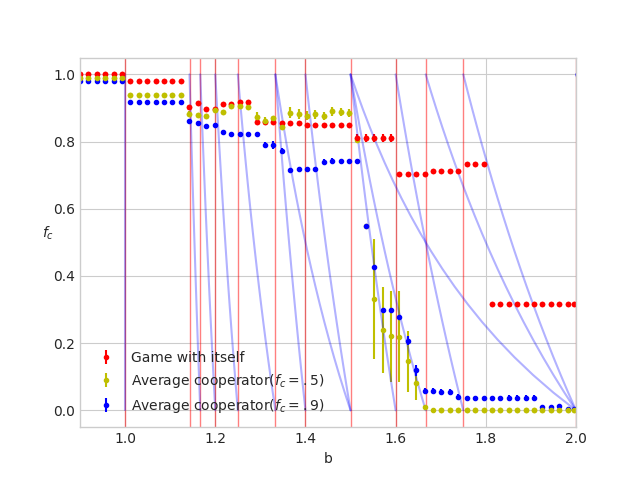

Text(0, 0.5, '$f_c$')

In [11]:
# fig = plt.figure()
plt.xlim(.9, 2)
# plt.suptitle('Средняя плотность кооператоров от $b$', fontsize=16)
plt.errorbar(bs, means_o, yerr=std_o, fmt=".r", label="Game with itself")
plt.errorbar(bs, means_n_5, yerr=std_n_5, fmt=".y", label="Average cooperator($f_c=.5$)")
plt.errorbar(bs, means_n, yerr=std_n, fmt=".b", label="Average cooperator($f_c=.9$)")
plt.legend(loc="lower left")
plt.xlabel("b")

for x in transitions_old: #[9/8, 8/7, 7/6, 6/5, 5/4, 9/7, 8/6, 7/5, 6/4, 8/5, 5/3, 7/4, 9/5, 2]:
    plt.axvline(x=x, linewidth=1, color='r', alpha=.5)

for x in transitions:
    plt.plot(x, f_cs, '-b', alpha=.3) #, label="For game with average")

plt.plot((8+f_cs)/(5+f_cs), f_cs, '-b', alpha=.3)
plt.ylabel("$f_c$", rotation=0)

In [12]:
# fig = plt.figure()
plt.xlim(.9, 2)
# plt.suptitle('Средняя плотность кооператоров от $b$', fontsize=16)
plt.errorbar(bs, means_o, yerr=std_o, fmt=".r", label="The game with itself")

plt.errorbar(bs[bs < 1.50001], means_n_5[bs < 1.50001], yerr=std_n_5[bs < 1.50001], fmt=".y", label="The game with average cooperator")
plt.errorbar(bs[bs > 1.6999], means_n_5[bs > 1.6999], yerr=std_n_5[bs > 1.6999], fmt=".y")
plt.errorbar(np.linspace(1.5, 1.7, 30), means_n_5_w, yerr=std_n_5_w, fmt=".y")

plt.errorbar(bs[bs < 1.50001], means_n[bs < 1.50001], yerr=std_n[bs < 1.50001], fmt=".b", label="The game with average cooperator")
plt.errorbar(bs[bs > 1.6999], means_n[bs > 1.6999], yerr=std_n[bs > 1.6999], fmt=".b")
plt.errorbar(np.linspace(1.5, 1.7, 30), means_n_w, yerr=std_n_w, fmt=".b")

plt.legend(loc="lower left")
plt.xlabel("b")

for x in transitions_old: #[9/8, 8/7, 7/6, 6/5, 5/4, 9/7, 8/6, 7/5, 6/4, 8/5, 5/3, 7/4, 9/5, 2]:
    plt.axvline(x=x, linewidth=1, color='r', alpha=.5)

for x in transitions:
    plt.plot(x, f_cs, '-b', alpha=.3) #, label="For game with average")

plt.plot((8+f_cs)/(5+f_cs), f_cs, '-b', alpha=.3)
plt.ylabel("$f_c$", rotation=0)

NameError: name 'means_n_5_w' is not defined

In [28]:
plt.savefig("figures/cooperators_density_at_different_b", dpi=500, quality=95)

## Zooming into [1.5, 1.7]

In [5]:
np.linspace(1.5, 1.7, 30)

array([1.5       , 1.50689655, 1.5137931 , 1.52068966, 1.52758621,
       1.53448276, 1.54137931, 1.54827586, 1.55517241, 1.56206897,
       1.56896552, 1.57586207, 1.58275862, 1.58965517, 1.59655172,
       1.60344828, 1.61034483, 1.61724138, 1.62413793, 1.63103448,
       1.63793103, 1.64482759, 1.65172414, 1.65862069, 1.66551724,
       1.67241379, 1.67931034, 1.6862069 , 1.69310345, 1.7       ])

In [10]:
game = MeanGame(L, 1.6)
density2 = []
for b in tqdm(np.linspace(1.5, 1.7, 30)):
    den = []
    game.b = b
    for i in range(len(seeds)):
        d = []
        game.field = np.load("fields/field_{}_{}.npy".format(L, i) )
        game.evolve(CALC//2)
        game.evolve(CALC - CALC//2)
        den.append(game.densities[DROP::EVERY].tolist())
    density2.append(den)
    
np.save("data/density_of_cooperators15-17.npy", np.asarray(density2))

100%|██████████| 30/30 [5:22:10<00:00, 652.41s/it]  


In [16]:
density2 = np.load("data/density_of_cooperators15-17.npy")
density52 = np.load("data/density_of_cooperators515-17.npy")

In [15]:
def mean_without_zeros(realizations):
    means = []
    for r in realizations:
        if r.mean() > .000001:
            means.append(r.mean())
    if len(means) == 0:
        return 0, 0
    else:
        return np.asarray(means).mean(), np.asarray(means).std()

In [12]:
density_new_wide = density2.mean(axis=-1)
density_new_5_wide = density52.mean(axis=-1)

std_n_w = density_new_wide.std(axis=-1)
std_n_5_w = density_new_5_wide.std(axis=-1)

means_n_w = density_new_wide.mean(axis=-1)
means_n_5_w = density_new_5_wide.mean(axis=-1)

In [17]:
density_new_wide = density2.mean(axis=-1)
density_new_5_wide = density52.mean(axis=-1)

std_n_w, std_n_5_w = [], []
means_n_w, means_n_5_w = [], []

for br in density_new_wide:
    m, d = mean_without_zeros(br)
    means_n_w.append(m)
    std_n_w.append(d)
    
for br in density_new_5_wide:
    m, d = mean_without_zeros(br)
    means_n_5_w.append(m)
    std_n_5_w.append(d)

<IPython.core.display.Javascript object>


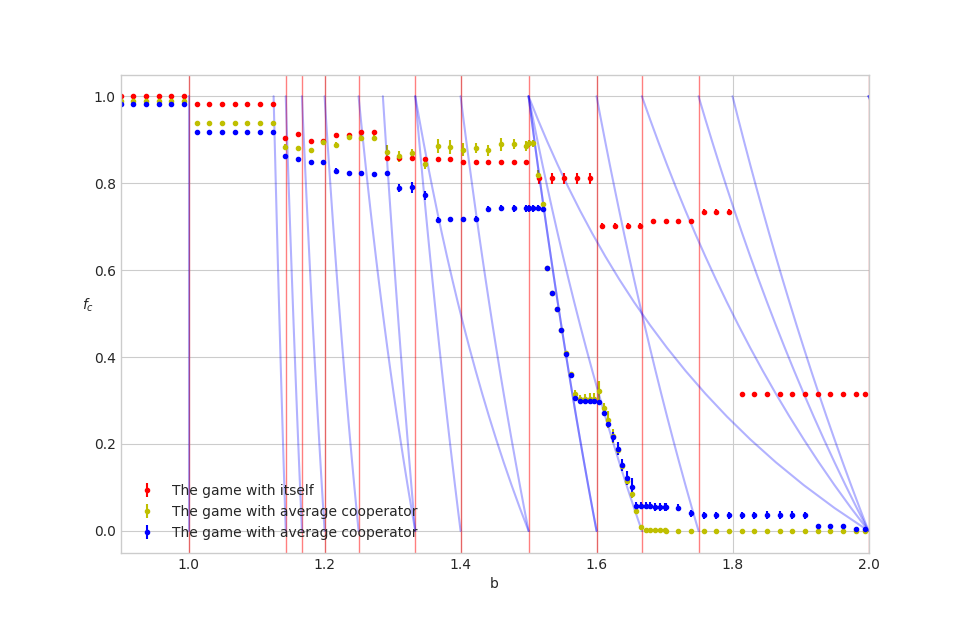

Text(0, 0.5, '$f_c$')

In [27]:
# fig = plt.figure()
plt.xlim(.9, 2)
# plt.suptitle('Средняя плотность кооператоров от $b$', fontsize=16)
plt.errorbar(bs, means_o, yerr=std_o, fmt=".r", label="The game with itself")

plt.errorbar(bs[bs < 1.50001], means_n_5[bs < 1.50001], yerr=std_n_5[bs < 1.50001], fmt=".y", label="The game with average cooperator")
plt.errorbar(bs[bs > 1.6999], means_n_5[bs > 1.6999], yerr=std_n_5[bs > 1.6999], fmt=".y")
plt.errorbar(np.linspace(1.5, 1.7, 30), means_n_5_w, yerr=std_n_5_w, fmt=".y")

plt.errorbar(bs[bs < 1.50001], means_n[bs < 1.50001], yerr=std_n[bs < 1.50001], fmt=".b", label="The game with average cooperator")
plt.errorbar(bs[bs > 1.6999], means_n[bs > 1.6999], yerr=std_n[bs > 1.6999], fmt=".b")
plt.errorbar(np.linspace(1.5, 1.7, 30), means_n_w, yerr=std_n_w, fmt=".b")

plt.legend(loc="lower left")
plt.xlabel("b")

for x in transitions_old: #[9/8, 8/7, 7/6, 6/5, 5/4, 9/7, 8/6, 7/5, 6/4, 8/5, 5/3, 7/4, 9/5, 2]:
    plt.axvline(x=x, linewidth=1, color='r', alpha=.5)

for x in transitions:
    plt.plot(x, f_cs, '-b', alpha=.3) #, label="For game with average")

plt.plot((8+f_cs)/(5+f_cs), f_cs, '-b', alpha=.3)
plt.ylabel("$f_c$", rotation=0)

<IPython.core.display.Javascript object>


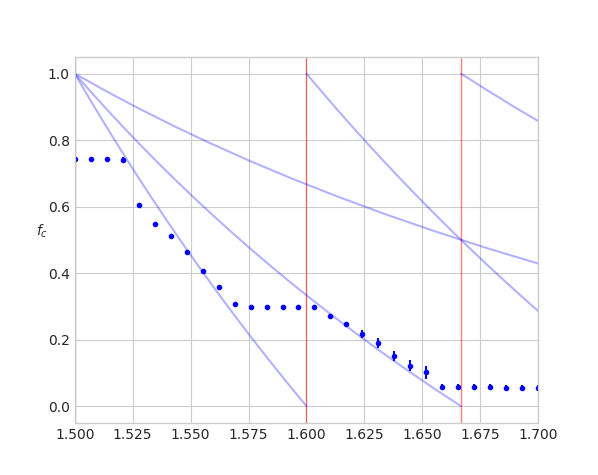

Text(0, 0.5, '$f_c$')

In [30]:
plt.xlim(1.5, 1.7)
plt.errorbar(np.linspace(1.5, 1.7, 30), means_n_w, yerr=std_n_w, fmt=".b", label="The game with average cooperator")
for x in transitions_old: #[9/8, 8/7, 7/6, 6/5, 5/4, 9/7, 8/6, 7/5, 6/4, 8/5, 5/3, 7/4, 9/5, 2]:
    plt.axvline(x=x, linewidth=1, color='r', alpha=.5)

for x in transitions:
    plt.plot(x, f_cs, '-b', alpha=.3) #, label="For game with average")
plt.plot((8+f_cs)/(5+f_cs), f_cs, '-b', alpha=.3)
plt.ylabel("$f_c$", rotation=0)

In [31]:
plt.savefig("figures/cooperators_density_at_different_b_wide_rus", dpi=500, quality=95)

## Initial condition on transitional line

In [73]:
BN = (5+np.arange(1, L**2, 200)/L**2)/(3+np.arange(1, L**2, 200)/L**2)

In [134]:
density2 = []
i = 0
for b, n in tqdm(zip(BN, np.arange(1, L**2, 200))):
    d = []
#     np.random.seed = 100
    field = np.asarray([1]*n+[0]*(L**2-n))
    np.random.shuffle(field)
    field = field.reshape((L, L))
    d.append(field.sum()/(1.*field.shape[0]*field.shape[1]))
    for _ in range(0, 100, 4):
        field = evolve(field, b, 4)
        d.append(field.sum()/(1.*field.shape[0]*field.shape[1]))
    density2.append(d)
    
# np.save("data/density_of_cooperators.npy", np.asarray(density))




0it [00:00, ?it/s]


1it [00:00,  3.42it/s]


2it [00:00,  3.44it/s]


3it [00:00,  3.46it/s]


4it [00:01,  3.31it/s]


5it [00:01,  3.41it/s]


6it [00:01,  3.52it/s]


7it [00:01,  3.61it/s]


8it [00:02,  3.74it/s]


9it [00:02,  3.77it/s]


10it [00:02,  3.78it/s]


11it [00:03,  3.72it/s]


12it [00:03,  3.68it/s]


13it [00:03,  3.62it/s]


14it [00:03,  3.61it/s]


15it [00:04,  3.70it/s]


16it [00:04,  3.74it/s]


17it [00:04,  3.80it/s]


18it [00:04,  3.83it/s]


19it [00:05,  3.87it/s]


20it [00:05,  3.87it/s]


21it [00:05,  3.86it/s]


22it [00:05,  3.89it/s]


23it [00:06,  3.76it/s]


24it [00:06,  3.71it/s]


25it [00:06,  3.69it/s]


26it [00:07,  3.70it/s]


27it [00:07,  3.79it/s]


28it [00:07,  3.80it/s]


29it [00:07,  3.80it/s]


30it [00:08,  3.88it/s]


31it [00:08,  3.89it/s]


32it [00:08,  3.93it/s]


33it [00:08,  4.00it/s]


34it [00:09,  3.86it/s]


35it [00:09,  3.73it/s]


36it [00:09,  3.73it/s]


37it [00:09,  3.80it/s]


38it [00:10,  3.91it/s]

<IPython.core.display.Javascript object>


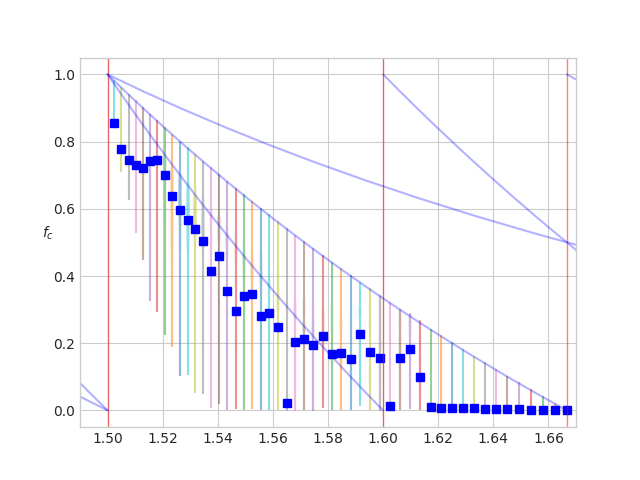

Text(0, 0.5, '$f_c$')

In [135]:
plt.xlim(1.49, 1.67)
for i, b in enumerate(BN):
    plt.plot([b]*26, density2[i],  alpha = .5)
    plt.plot(b, np.mean(density2[i]), "bs")


for x in transitions_old: #[9/8, 8/7, 7/6, 6/5, 5/4, 9/7, 8/6, 7/5, 6/4, 8/5, 5/3, 7/4, 9/5, 2]:
    plt.axvline(x=x, linewidth=1, color='r', alpha=.5)

for x in transitions:
    plt.plot(x, f_cs, '-b', alpha=.3) #, label="For game with average")
    
plt.plot((8+f_cs)/(5+f_cs), f_cs, '-b', alpha=.3)

plt.ylabel("$f_c$", rotation=0)

## Checking if density dependents on the initial density

In [10]:
game = MeanGame(L, 1.6)

In [11]:
density = []
for p_c in [.7, .5, .3]:
    den_inter = [] 
    for b in tqdm(bs):
        den = []
        for seed in seeds[:25]:
            np.random.seed(seed)
            game.b = b
            game.field = np.random.choice((0, 1), (L, L), p=(1-p_c, p_c))
            game.evolve(CALC//2)
            game.evolve(CALC - CALC//2)
            den.append(game.densities[DROP::EVERY].tolist())
            
        den_inter.append(den)
    density.append(den_inter)
    
np.save("data/density_of_cooperators.7.5.3.npy", np.asarray(density))

100%|██████████| 60/60 [6:43:28<00:00, 396.86s/it]  


In [13]:
den

[]

In [10]:
density_9_raw = np.load("data/density_of_cooperators.npy")[:, :20, :1500]
density_all_raw = np.load("data/density_of_cooperators.7.5.3.npy")

In [15]:
density_all_raw = np.concatenate((density_9_raw.reshape((1, 60, 20, 1500)), density_all_raw))

In [16]:
density_all_raw.shape

(5, 60, 20, 1500)

In [11]:
density_new = density_all_raw.mean(axis=-1)

std = density_new.std(axis=-1)

means = density_new.mean(axis=-1)

<IPython.core.display.Javascript object>


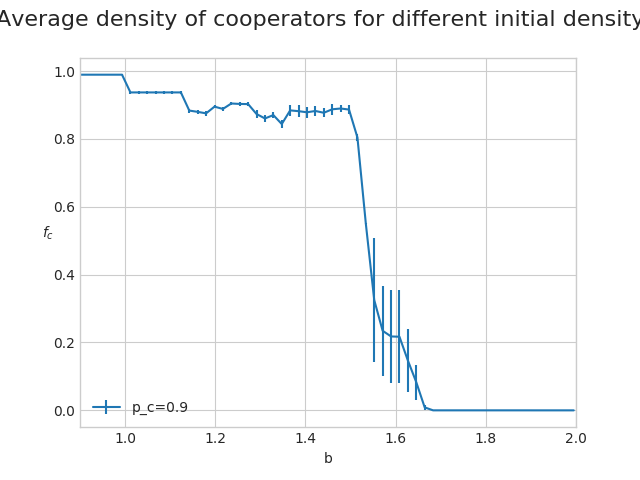

Text(0, 0.5, '$f_c$')

In [12]:
# fig = plt.figure()
plt.xlim(.9, 2)
plt.suptitle('Average density of cooperators for different initial density', fontsize=16)
# for i, p_c in enumerate([.7, .5, .3]):
#     plt.errorbar(bs, means[i], yerr=std[i], label="p_c={}".format(p_c))
plt.errorbar(bs, means[1], yerr=std[1], label="p_c={}".format(p_c))
plt.legend(loc="lower left")
plt.xlabel("b")

# for x in transitions:
#     plt.plot(x, f_cs, '-b', alpha=.3) #, label="For game with average")

# plt.plot((8+f_cs)/(5+f_cs), f_cs, '-b', alpha=.3)
plt.ylabel("$f_c$", rotation=0)

In [32]:
plt.savefig("figures/cooperators_density_for_diff_initial.png", dpi=300, quality=95)